# Portfolio Optimization

In this project we will analyze data from seven stocks in the stock market to find the best allocation for my portfolio. 

Here are some questions we will try to answer.
* What was the change in a stock's price over time?
* What was the daily return average of each stock?
* What are the expected returns for each stock (annualized vs daily)?
* What stock had the highest/lowest expected returns?
* What stock had the highest/lowest risk(volatility)?
* How are these stocks correlated?
* How do Individual stocks compare vs Efficient Portfolio


## If I had 100k to invest, how would I allocate my portfolio for highest return for the lowest risk?



In [1]:
#Import from python libraries
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import cvxopt as opt
import matplotlib.pyplot as plt
from cvxopt import blas, solvers
from datetime import datetime
import math


from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import EfficientFrontier
from pypfopt import expected_returns

In [2]:
# Function to generate 10,000 random portfolio combinations
def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 10000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df

In [3]:
#function to calculate the efficient frontier
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

## Data collected from July 1, 2018 - July 1, 2021

In [4]:
# Pulling stock data from Yahoo Finance API
symbols = ['FANG', 'TSLA', 'WFC', 'BIDU', 'CRM', 'SQ', 'AAPL']
start_date = datetime(2018,7,1) # Year, Month, Day
end_date = datetime(2021,7,1) # Year, Month, Day

stock_data = web.get_data_yahoo(symbols, start_date, end_date)

stock_data = stock_data['Adj Close']
#stock_data.tail()

In [5]:
# checking data accuracy
stock_data

Symbols,FANG,TSLA,WFC,BIDU,CRM,SQ,AAPL
Date,,,,,,,
2018-07-02,120.542519,67.014000,50.345261,246.250000,140.429993,63.139999,45.053963
2018-07-03,121.241730,62.172001,49.665890,246.429993,137.839996,61.750000,44.269291
2018-07-05,123.059662,61.832001,49.379841,244.070007,139.770004,64.150002,44.625519
2018-07-06,125.828514,61.779999,49.960876,251.770004,141.399994,66.440002,45.244110
2018-07-09,127.413376,63.702000,50.747532,261.970001,141.759995,66.480003,45.872341
...,...,...,...,...,...,...,...
2021-06-25,94.922882,671.869995,45.795773,202.639999,241.869995,239.940002,132.548294
2021-06-28,91.138199,688.719971,45.213203,205.179993,244.570007,246.600006,134.211243
2021-06-29,91.286034,680.760010,44.225800,207.669998,245.809998,248.869995,135.754700


## What was the change in a stock's price over time?

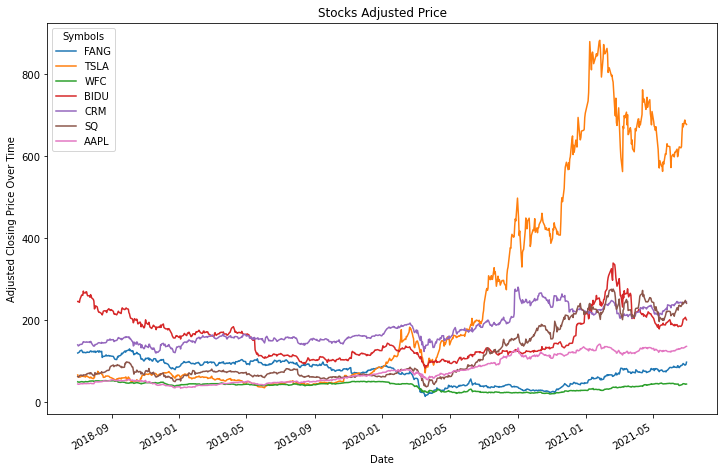

In [6]:
# Comparing stock price over time

stock_data.plot(figsize=(12,8)) 
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price Over Time')
plt.title('Stocks Adjusted Price')

plt.show()

## What was the daily return average of the stocks?

In [7]:
#show the daily log returns
stock_returns = stock_data.pct_change()[1:]
stock_returns

Symbols,FANG,TSLA,WFC,BIDU,CRM,SQ,AAPL
Date,,,,,,,
2018-07-03,0.005801,-0.072254,-0.013494,0.000731,-0.018443,-0.022015,-0.017416
2018-07-05,0.014994,-0.005469,-0.005759,-0.009577,0.014002,0.038866,0.008047
2018-07-06,0.022500,-0.000841,0.011767,0.031548,0.011662,0.035698,0.013862
2018-07-09,0.012595,0.031110,0.015745,0.040513,0.002546,0.000602,0.013885
2018-07-10,-0.019829,0.012433,-0.002643,-0.002748,0.004867,-0.025872,-0.001207
...,...,...,...,...,...,...,...
2021-06-25,0.021857,-0.011694,0.026560,0.040407,-0.007794,-0.017243,-0.002249
2021-06-28,-0.039871,0.025079,-0.012721,0.012535,0.011163,0.027757,0.012546
2021-06-29,0.001622,-0.011558,-0.021839,0.012136,0.005070,0.009205,0.011500


## What are the expected returns for each stock (annualized vs daily)?

In [8]:
mu2 = expected_returns.mean_historical_return(stock_data)
S = CovarianceShrinkage(stock_data).ledoit_wolf()

mu2

Symbols
FANG   -0.066244
TSLA    1.164951
WFC    -0.037929
BIDU   -0.064812
CRM     0.204103
SQ      0.565566
AAPL    0.448377
dtype: float64

In [9]:
mu = stock_returns.mean()
mu

Symbols
FANG    0.000740
TSLA    0.004036
WFC     0.000178
BIDU    0.000153
CRM     0.001040
SQ      0.002505
AAPL    0.001722
dtype: float64


## What stock had the highest/lowest expected returns?
### Highest rate of return: TESLA
### Lowest rate of return: FANG

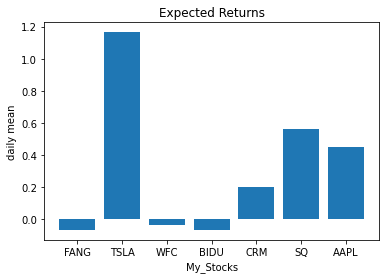

In [10]:
# grab each daily mean value for the y axis
height = []
for key in mu2.keys():
    height.append(mu2[key])
    
x_pos = np.arange(len(mu2.keys()))

# plot bars
plt.bar(x_pos, height)
 
# create names on the x-axis
plt.xticks(x_pos, mu2.keys())

# label chart
plt.xlabel("My_Stocks")
plt.ylabel("daily mean")
plt.title("Expected Returns")

# show graphic
plt.show()

In [11]:
#variance covariance matrix
cov_matrix = stock_returns.cov()
cov_matrix

Symbols,FANG,TSLA,WFC,BIDU,CRM,SQ,AAPL
Symbols,,,,,,,
FANG,0.001929,0.000466,0.000585,0.000345,0.000265,0.000433,0.000269
TSLA,0.000466,0.001945,0.000234,0.000459,0.000457,0.000706,0.000425
WFC,0.000585,0.000234,0.000662,0.000208,0.000214,0.000294,0.000226
BIDU,0.000345,0.000459,0.000208,0.000842,0.000280,0.000481,0.000280
CRM,0.000265,0.000457,0.000214,0.000280,0.000615,0.000551,0.000330
SQ,0.000433,0.000706,0.000294,0.000481,0.000551,0.001425,0.000479
AAPL,0.000269,0.000425,0.000226,0.000280,0.000330,0.000479,0.000501


# What stock had the highest/lowest risk(volatility)?
## Highest volatility(riskiest): Tesla
## Lowest volatility: Apple

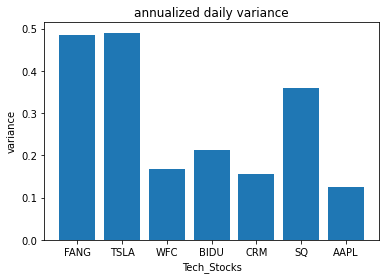

In [12]:
# calculate variance
daily_var = stock_returns.var() * 252 

# grab each daily mean value for the y axis
height = []
for key in daily_var.keys():
    height.append(daily_var[key])


# arrange keys on x axis based on length
x_pos = np.arange(len(daily_var.keys()))


# plot bars
plt.bar(x_pos, height)
 
# create names on the x-axis
plt.xticks(x_pos, daily_var.keys())

# label chart
plt.xlabel("Tech_Stocks")
plt.ylabel("variance")
plt.title("annualized daily variance")

# show graphic
plt.show()

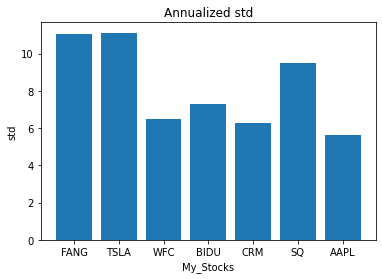

In [13]:
#calculate the annualized std dev 
std = np.sqrt(daily_var * 252)

# grab each standard deviation value for the y axis
height = []
# for key in daily_std.keys():
#     height.append(daily_std[key])
# height

for key in std.keys():
    height.append(std[key])
# arrange keys on x axis based on length
#x_pos = np.arange(len(daily_std.keys()))
x_pos = np.arange(len(std.keys()))

# plot bars
plt.bar(x_pos, height)
 
# create names on the x-axis
#plt.xticks(x_pos, daily_std.keys())
plt.xticks(x_pos, std.keys())
# label chart
plt.xlabel("My_Stocks")
plt.ylabel("std")
plt.title("Annualized std")

# show graphic
plt.show()

## How are these stocks correlated?

In [14]:
#calculate correlation matrix
stock_returns.corr()

Symbols,FANG,TSLA,WFC,BIDU,CRM,SQ,AAPL
Symbols,,,,,,,
FANG,1.000000,0.240387,0.517538,0.271022,0.243505,0.261434,0.274201
TSLA,0.240387,1.000000,0.206655,0.358578,0.417851,0.423844,0.430097
WFC,0.517538,0.206655,1.000000,0.279328,0.334845,0.302610,0.392795
BIDU,0.271022,0.358578,0.279328,1.000000,0.389197,0.439312,0.431584
CRM,0.243505,0.417851,0.334845,0.389197,1.000000,0.588629,0.594031
SQ,0.261434,0.423844,0.302610,0.439312,0.588629,1.000000,0.566571
AAPL,0.274201,0.430097,0.392795,0.431584,0.594031,0.566571,1.000000


In [15]:
selected = list(stock_data.columns) 

cov_daily = stock_returns.cov() 




In [16]:
stock_returns = stock_data[selected].pct_change() 
expected_returns = stock_returns.mean() 
cov_quarterly = stock_returns.cov() 

single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
my_portfolio = return_portfolios(expected_returns, cov_quarterly) 
weights, returns, risks = optimal_portfolio(stock_returns[1:])


# df.plot.scatter(x='Volatility', y='Returns', fontsize=12)
# plt.plot(risks, returns, 'y-o')
# plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)
# plt.show()

     pcost       dcost       gap    pres   dres
 0: -1.4693e-03 -1.0040e+00  1e+00  1e-16  3e+00
 1: -1.4727e-03 -1.3993e-02  1e-02  1e-16  4e-02
 2: -1.7257e-03 -4.0849e-03  2e-03  7e-17  7e-03
 3: -3.5517e-03 -5.0129e-03  1e-03  3e-16  2e-03
 4: -3.9040e-03 -3.9494e-03  5e-05  1e-16  6e-05
 5: -3.9383e-03 -3.9387e-03  5e-07  4e-19  6e-07
 6: -3.9386e-03 -3.9386e-03  5e-09  9e-21  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4663e-03 -1.0040e+00  1e+00  2e-16  3e+00
 1: -1.4697e-03 -1.3988e-02  1e-02  1e-16  4e-02
 2: -1.7222e-03 -4.0787e-03  2e-03  9e-17  7e-03
 3: -3.5487e-03 -5.0024e-03  1e-03  9e-16  2e-03
 4: -3.8926e-03 -3.9375e-03  4e-05  4e-18  6e-05
 5: -3.9264e-03 -3.9269e-03  4e-07  1e-16  6e-07
 6: -3.9267e-03 -3.9267e-03  4e-09  2e-16  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4630e-03 -1.0040e+00  1e+00  0e+00  3e+00
 1: -1.4663e-03 -1.3982e-02  1e-02  7e-17  4e-02
 2: -1.7183e-03 -4.0718e

## How do Individual stocks compare vs Efficient Portfolio

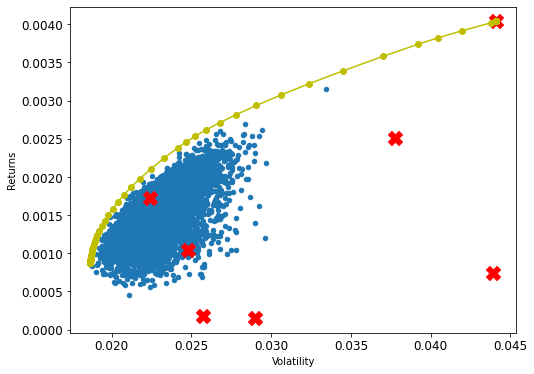

In [17]:
#plotting the efficient frontier vs individual stocks

my_portfolio.plot.scatter(x='Volatility', y='Returns', fontsize=12, figsize = (8,6))

plt.plot(risks, returns, 'y-o')

plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)



## Optimal portfolio vs least risky portfolio

* The Green Star represents the optimal portfolio (highest return for lowest risk).
* The Red Star represents the least risky portfolio(portfolio for risk adverse investors).

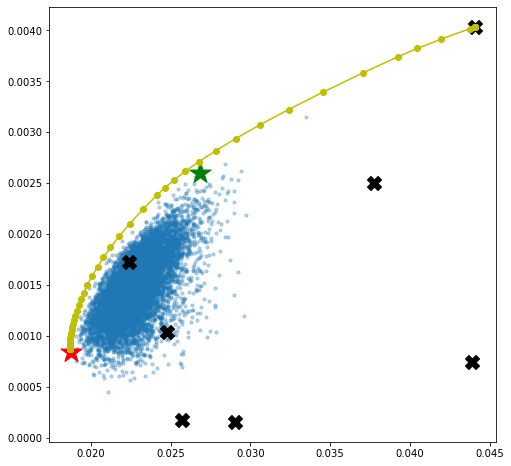

In [23]:
#Plotting optimal portfolio
rf = 0
min_vol = my_portfolio.iloc[my_portfolio['Volatility'].idxmin()]
optimal_risk = my_portfolio.iloc[((my_portfolio['Returns']-rf)/my_portfolio['Volatility']).idxmax()]




plt.subplots(figsize=(8,8))
#df.plot.scatter(x='Volatility', y='Returns', fontsize=12)
plt.plot(risks, returns, 'y-o')

plt.scatter(my_portfolio['Volatility'], my_portfolio['Returns'], marker ='o', s=10, alpha=0.3)
plt.scatter(min_vol[1], min_vol[0], color = 'red', marker = '*', s = 500) 
plt.scatter(optimal_risk[1], optimal_risk[0], color = 'g', marker = '*', s=500)
plt.scatter(single_asset_std,expected_returns,marker='X',color='black',s=200)
plt.show()

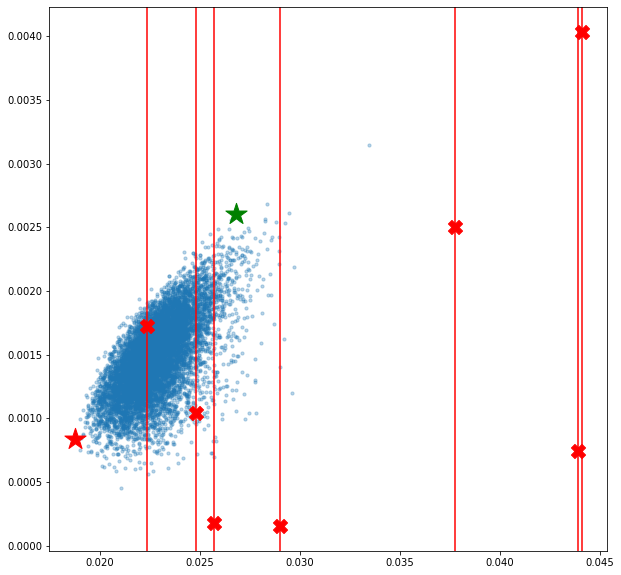

In [19]:
#plotting the individual stocks vs the optimal portfolio
single_asset_std=np.sqrt(np.diagonal(cov_daily))

plt.subplots(figsize=(10,10))
plt.scatter(my_portfolio['Volatility'], my_portfolio['Returns'], marker ='o', s=10, alpha=0.3)
plt.scatter(min_vol[1], min_vol[0], color = 'red', marker = '*', s = 500) 
plt.scatter(optimal_risk[1], optimal_risk[0], color = 'g', marker = '*', s=500)

plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)
for xc in single_asset_std:
    plt.axvline(x=xc, color='red')

In [20]:
optimal_risk

Returns        0.002603
Volatility     0.026822
FANG Weight    0.003526
TSLA Weight    0.339934
WFC Weight     0.008420
BIDU Weight    0.046506
CRM Weight     0.009103
SQ Weight      0.242569
AAPL Weight    0.349943
Name: 3321, dtype: float64

In [21]:
min_vol

Returns        0.000839
Volatility     0.018753
FANG Weight    0.009274
TSLA Weight    0.011583
WFC Weight     0.307500
BIDU Weight    0.190711
CRM Weight     0.186804
SQ Weight      0.000655
AAPL Weight    0.293474
Name: 8186, dtype: float64

### My goal is to minimize volatility and maximize expected return
### If I had 100k in my portfolio...
### I would allocate:
### TSLA = 41.9K, AAPL = 36.9k, CRM = 8.9k, SQ = 6K, WFC = 3.5k, FANG = 2.1k, BIDU = .4K  